In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')
from src.encode_data import *
from src.midi_data import *
from src.data_sources import process_all, arr2csv
from src.midi_transform import *
from src.fastai_data import *

In [3]:
import traceback
import time

## Standardize and reformat raw midi files before encoding to text
- Transform key to C major
- Remove unused instruments
- Combine multiple tracks with the same instrument into a single part
- Melody, Piano, String

### Load midi data

In [4]:
version = 'v17'
data_path = Path('data/midi')
version_path = data_path/version

In [5]:
# input_file = 'data/midi/v16/midi_sources/from_mxl/ecomp/2008/Kociuban16.mid' # out of bounds
# input_file = 'data/midi/v16/midi_sources/midiworld/named_midi/Huey_Lewis_-_Perfect_World.mid'
# input_file = 'data/midi/v16/midi_sources/hooktheory/pianoroll/w/wan-wan/sky-filling-departed-spirit---lightning-word/bridge_key_original.mid'

In [6]:
# input_file = 'data/midi/v16/midi_sources/lmd_clean/Blondie/Dreaming.mid' # out of memory

In [7]:
# duration out of range
# input_file = 'data/midi/v16/midi_sources/hooktheory/pianoroll/y/yevgueni/welkenraedt/intro-and-verse_key_original.mid'


In [8]:
# colliding melody and chords
input_file = 'data/midi/v17/midi_sources/hooktheory/pianoroll/g/guang-liang/tong-hua/chorus_key_cmajor.mid'


In [9]:
stream = file2stream(input_file)

In [10]:
stream.flat.highestTime * 4

152.0

In [11]:
stream.flat.getElementsByClass('Note').highestTime, stream.flat.getElementsByClass('Chord').highestTime

(34.5, 38.0)

In [12]:
sample_freq = 12
maxTimeStep = round(stream.flat.highestTime * sample_freq)+1; maxTimeStep

457

In [13]:
stream.show('text')

{0.0} <music21.stream.Part 0x7fcb1fc65048>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.tempo.MetronomeMark adagietto Quarter=67.0>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest rest>
    {2.5} <music21.note.Note G>
    {3.0} <music21.note.Note G>
    {3.5} <music21.note.Note F>
    {4.0} <music21.note.Note E>
    {4.5} <music21.note.Rest rest>
    {5.0} <music21.note.Note E>
    {5.5} <music21.note.Note F>
    {5.75} <music21.note.Note E>
    {6.25} <music21.note.Rest rest>
    {7.0} <music21.note.Note E>
    {7.5} <music21.note.Note F>
    {8.0} <music21.note.Note E>
    {8.5} <music21.note.Note F>
    {9.0} <music21.note.Note E>
    {9.5} <music21.note.Note D>
    {9.75} <music21.note.Note C>
    {10.25} <music21.note.Rest rest>
    {10.5} <music21.note.Note C>
    {11.0} <music21.note.Note E>
    {11.5} <music21.note.Note G>
    {12.0} <music21.note.Note A>
    {13.0} <music21.note.Note A>
    {13.5}

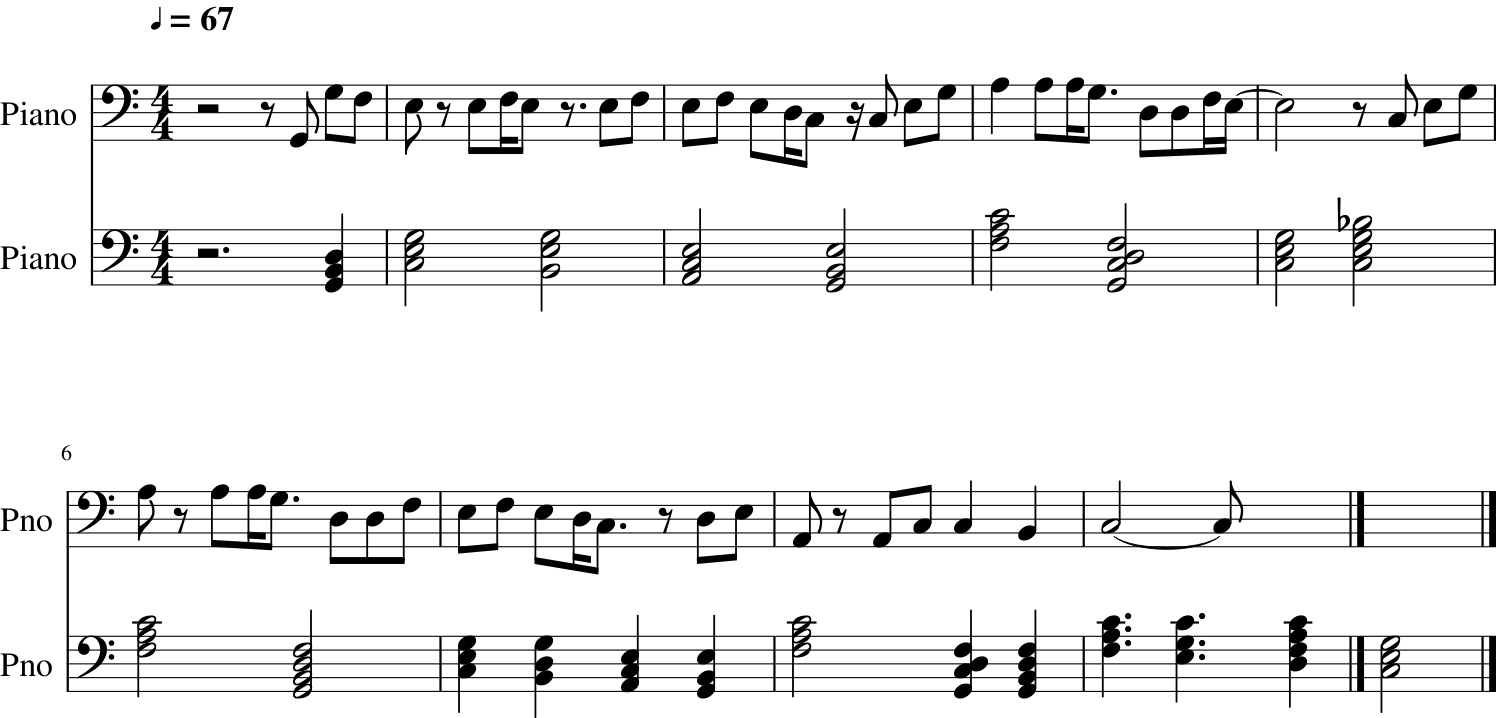

In [14]:
stream.show()

In [15]:
stream.show('midi')

In [16]:
chordarr = stream2chordarr(stream)

In [17]:
npenc = chordarr2npenc(chordarr); npenc.shape

(178, 2)

In [18]:

# 1.
def npenc2chordarr(npenc, note_size=NOTE_SIZE):
    max_vals = npenc.max(axis=0)
    num_instruments = 1 if len(npenc.shape) <= 2 else max_vals[-1]
    
    max_len = npenc_len(npenc)
    # score_arr = (steps, inst, note)
    score_arr = np.zeros((max_len, num_instruments, note_size))
    
    idx = 0
    for step in npenc:
        n,d,i = (step.tolist()+[0])[:3] # or n,d,i
        if n < VALTSEP: continue # special token
        if n == VALTSEP:
            idx += d
            continue
        score_arr[idx,i,n] = d
    return score_arr

def npenc_len(npenc):
    duration = 0
    for t in npenc:
        if t[0] == VALTSEP: duration += t[1]
    return duration + 1


# 2.
def chordarr2stream(arr, sample_freq=SAMPLE_FREQ, bpm=120):
    duration = music21.duration.Duration(1. / sample_freq)
    stream = music21.stream.Stream()
    stream.append(music21.meter.TimeSignature(TIMESIG))
    stream.append(music21.tempo.MetronomeMark(number=bpm))
    stream.append(music21.key.KeySignature(0))
    for inst in range(arr.shape[1]):
        p = partarr2stream(arr[:,inst,:], duration, stream=music21.stream.Part())
        stream.append(p)
    stream = stream.transpose(0)
    return stream

# 2b.
def partarr2stream(partarr, duration, stream=None):
    "convert instrument part to music21 chords"
    if stream is None: stream = music21.stream.Stream()
    stream.append(music21.instrument.Piano())
    part_append_duration_notes(partarr, duration, stream) # notes already have duration calculated

    return stream

def part_append_duration_notes(partarr, duration, stream):
    "convert instrument part to music21 chords"
    for tidx,t in enumerate(partarr):
        note_idxs = np.where(t > 0)[0] # filter out any negative values (continuous mode)
        if len(note_idxs) == 0: continue
        notes = []
        for nidx in note_idxs:
            note = music21.note.Note(nidx)
            note.duration = music21.duration.Duration(partarr[tidx,nidx]*duration.quarterLength)
            notes.append(note)
        for g in group_notes_by_duration(notes):
            if len(g) == 1:
                stream.insert(tidx*duration.quarterLength, g[0])
            else:
                chord = music21.chord.Chord(g)
                stream.insert(tidx*duration.quarterLength, chord)
    return stream

In [19]:
# seperates overlapping notes to different tracks
def remove_overlaps(stream, separate_chords=True):
    if not separate_chords:
        return stream.flat.makeVoices().voicesToParts()
    return separate_melody_chord(stream)

# seperates notes and chords to different tracks
def separate_melody_chord(stream):
    new_stream = music21.stream.Stream()
    new_stream.append(stream.timeSignature)
    new_stream.append(stream.metronomeMarkBoundaries()[0][-1])
    new_stream.append(stream.keySignature)
    
    melody_part = music21.stream.Part(stream.flat.getElementsByClass('Note'))
    melody_part.insert(0, stream.getInstrument())
    chord_part = music21.stream.Part(stream.flat.getElementsByClass('Chord'))
    chord_part.insert(0, stream.getInstrument())
    new_stream.append(melody_part)
    new_stream.append(chord_part)
    return new_stream

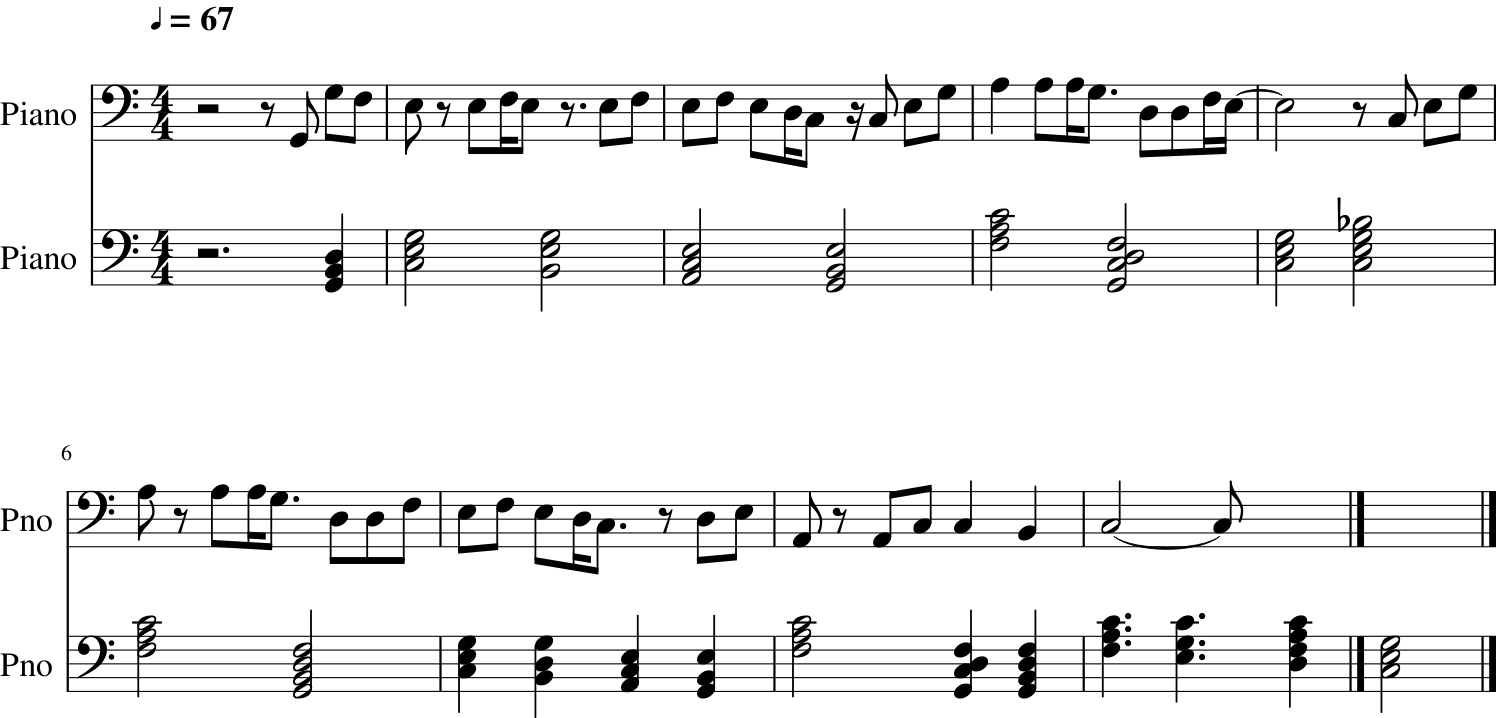

In [20]:
stream.show()

In [21]:
stream.show('midi')

In [22]:
s = chordarr2stream(npenc2chordarr(npenc))

In [23]:
s.show('text')

{0.0} <music21.stream.Part 0x7fcb1f794470>
    {0.0} <music21.instrument.Piano Piano>
    {2.5} <music21.note.Note G>
    {3.0} <music21.note.Note G>
    {3.0} <music21.chord.Chord G2 B2 D3>
    {3.5} <music21.note.Note F>
    {4.0} <music21.chord.Chord C3 E3 G3>
    {5.0} <music21.note.Note E>
    {5.5} <music21.note.Note F>
    {5.75} <music21.note.Note E>
    {6.0} <music21.chord.Chord B2 E3 G3>
    {7.0} <music21.note.Note E>
    {7.5} <music21.note.Note F>
    {8.0} <music21.chord.Chord A2 C3 E3>
    {8.5} <music21.note.Note F>
    {9.0} <music21.note.Note E>
    {9.5} <music21.note.Note D>
    {9.75} <music21.note.Note C>
    {10.0} <music21.chord.Chord G2 B2 E3>
    {10.5} <music21.note.Note C>
    {11.0} <music21.note.Note E>
    {11.5} <music21.note.Note G>
    {12.0} <music21.chord.Chord F3 A3 C4>
    {13.0} <music21.note.Note A>
    {13.5} <music21.note.Note A>
    {13.75} <music21.note.Note G>
    {14.0} <music21.chord.Chord G2 C3 D3 F3>
    {14.5} <music21.note.Note D>
   

In [24]:
s_sep = separate_melody_chord(s)

In [25]:
# s = npenc2stream(npenc)

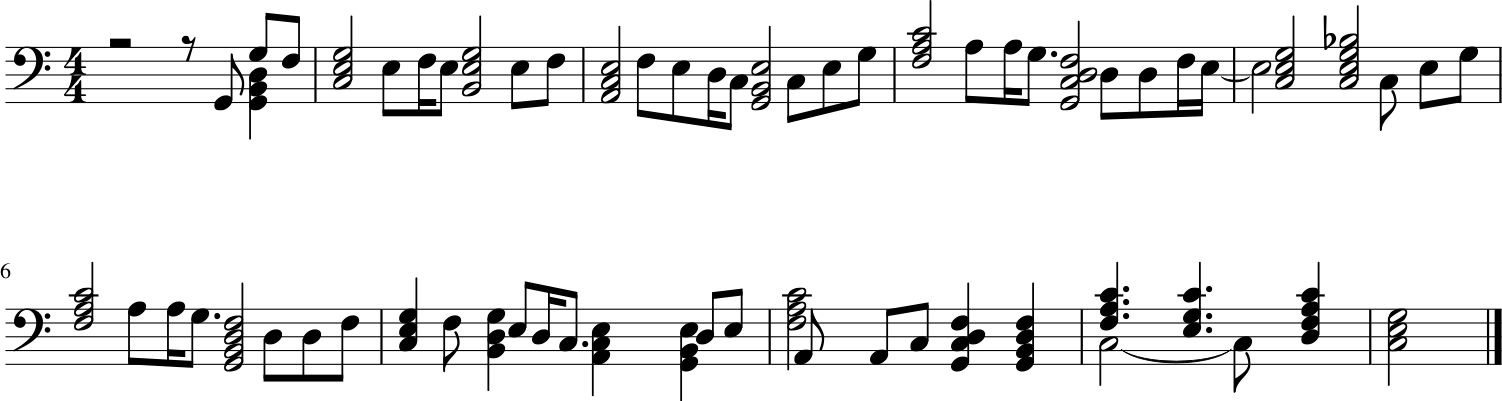

In [26]:
s.show()

In [27]:
s.show('midi')

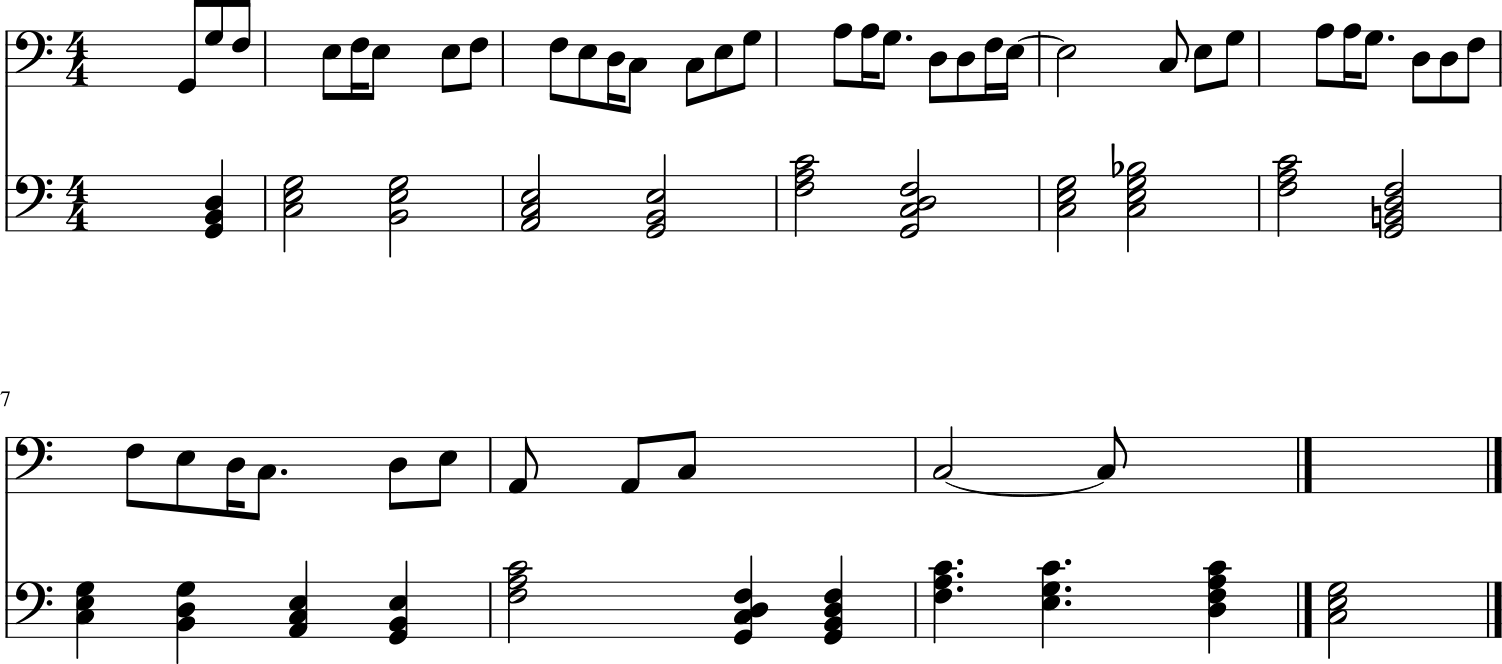

In [28]:
s_sep.show()

In [80]:
# s.flat.makeVoices().voicesToParts().write('midi', '/tmp/12345.mid')

'/tmp/12345.mid'

In [29]:
s_sep.write('midi', '/tmp/1.mid')

'/tmp/1.mid'

In [30]:
mf = file2mf('/tmp/1.mid')

In [31]:
s2 = music21.midi.translate.midiFileToStream(mf)

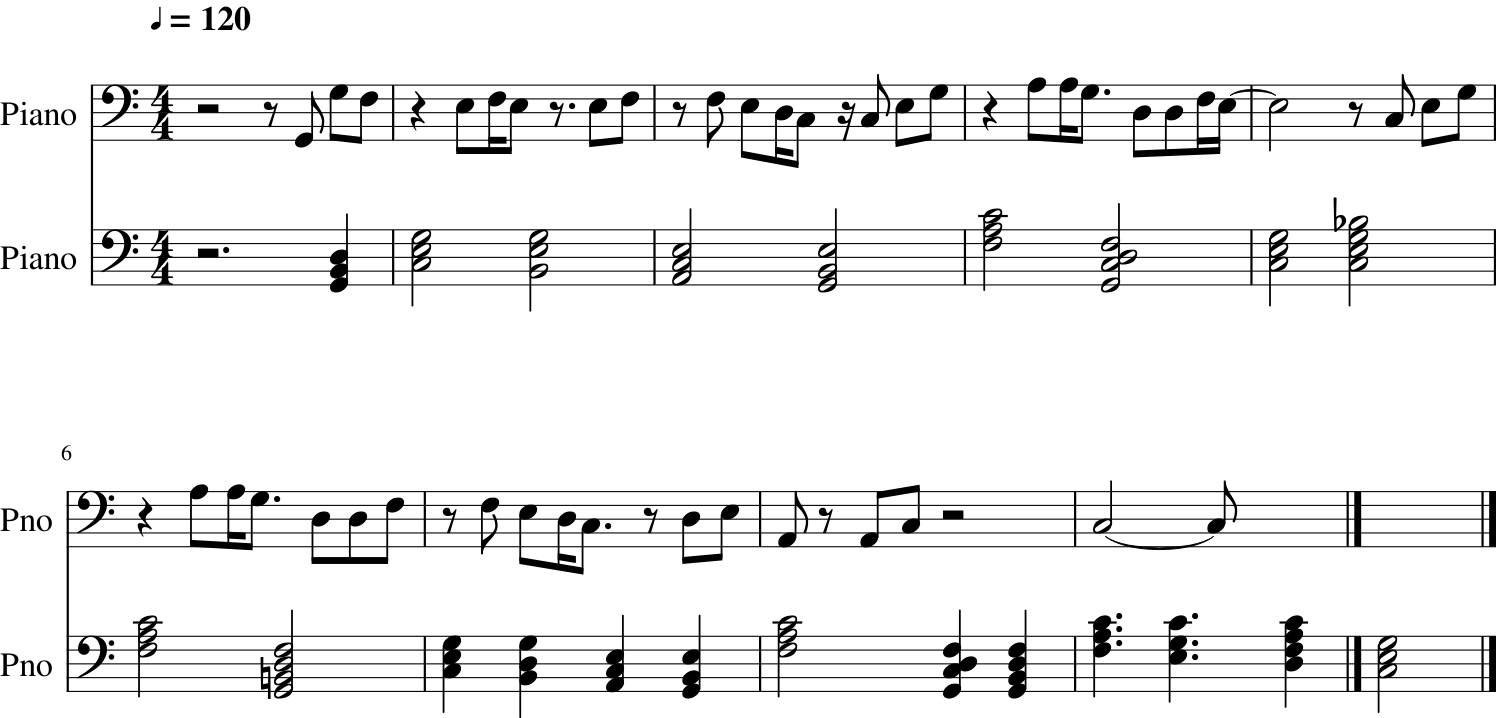

In [33]:
s2.show()

In [34]:
s2.show('midi')

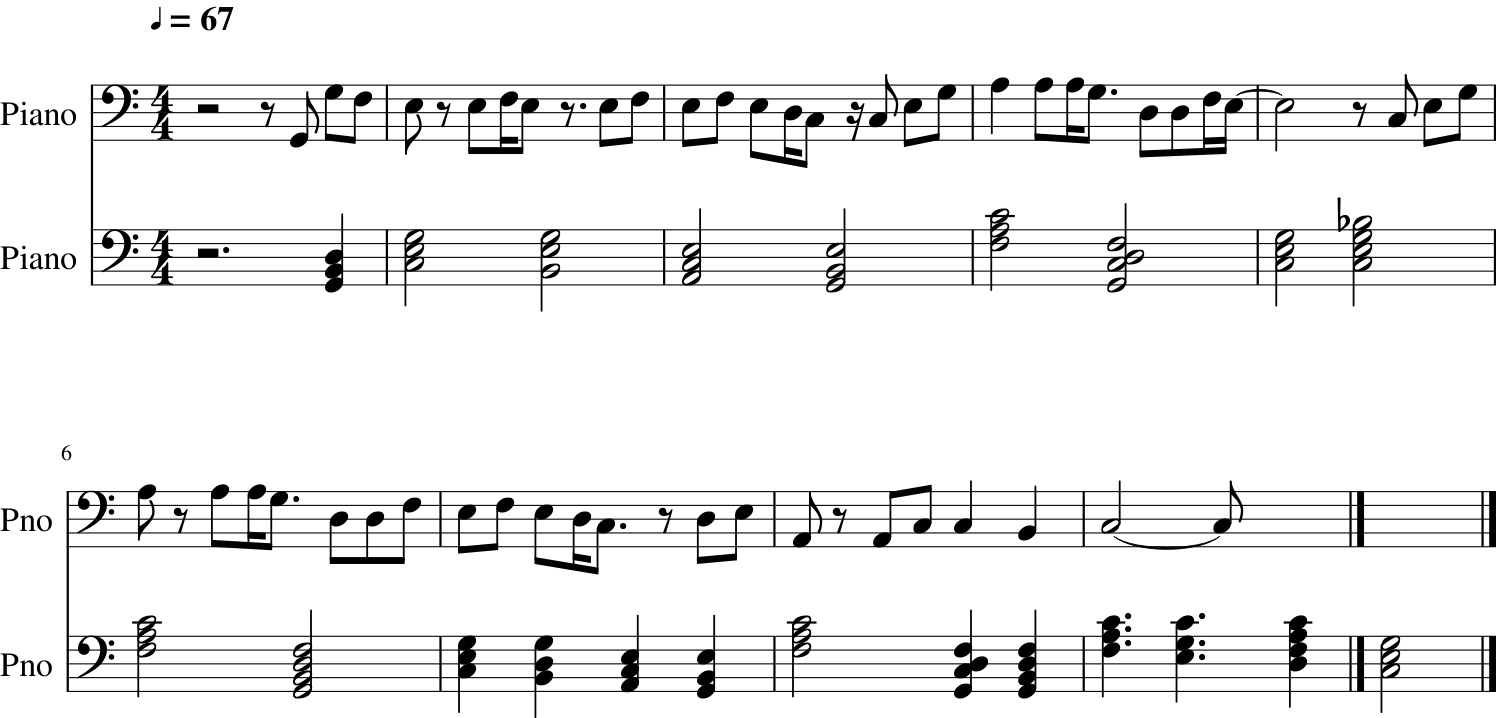

In [85]:
stream.show()